In [1]:
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.DataFrame.iteritems = pd.DataFrame.items
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Loading and transforming data, followed by creating data loaders for the train, validation, and test data.

In [2]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lars_root = 'C:/Users/larsy/Downloads/Data-20240621T134700Z-001/Data'
robb_root = 'C:/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/Data'
dataset = ImageFolder(root=robb_root, transform=transform)

torch.manual_seed(43)
train, test, val = random_split(dataset, [0.7, .15, .15])
b_s = 4
train_loader = DataLoader(train, batch_size = b_s, shuffle=True)
test_loader = DataLoader(test, batch_size = 1, shuffle=False)
val_loader = DataLoader(val, batch_size = 1, shuffle=False)

classes = dataset.classes

Displaying some sample images from the dataset and their labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


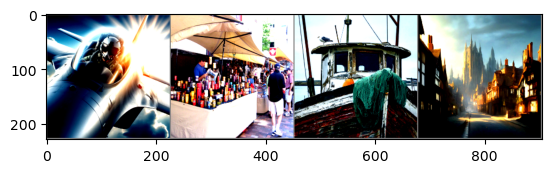

GroundTruth:  Fake_Copilot Real  Fake_Gemini Fake_Gemini


In [3]:
\dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(b_s)))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

__Model 1: GoogleNet__

In [5]:
googlenet = models.googlenet(weights = None)
googlenet = googlenet.to(device)

C:\Users\robb4\anaconda3\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [6]:
googlenet.fc = nn.Linear(1024, len(classes), bias = True)

In [7]:
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(googlenet.parameters(), lr=0.0015, weight_decay = 0.001)

In [8]:
tng_loss_list_1 = []
val_loss_list_1 = []
test_loss_list_1 = []
tng_acc_list_1 = []
val_acc_list_1 = []
test_acc_list_1 = []
correct = 0
total = 0
lr = 0.001

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(googlenet.parameters(), lr=lr, weight_decay = 0.001)

googlenet.zero_grad()

prev_epoch1 = -1
epoch1 = 0
failure_counter1 = 0

#for epoch in range(epoch):
while failure_counter1 <= 3:
    
    googlenet.train().to(device)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_1.zero_grad()
        outputs = googlenet(inputs)
        outputs = outputs.logits
        loss = criterion_1(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'{epoch1+1}, loss: {running_loss / len(train):.3f}')
    tng_loss_list_1.append(running_loss / len(train))
    tng_acc_list_1.append(100 * correct // total)
    running_loss = 0.0
    
    ## Validation Stats ##
    
    correct = 0
    total = 0
    googlenet.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = googlenet(inputs)
            loss = criterion_1(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_acc_list_1.append(100 * correct // total)
    val_loss_list_1.append(running_loss / len(val))
    
    if epoch1 > 1 and tng_loss_list_1[epoch1] > tng_loss_list_1[prev_epoch1]:
        lr = lr/1.5
        print(f'Updated Learning rate:{lr:.5f}')
        failure_counter1 += 1
    
    ## Test Stats ##
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #labels = labels.type(torch.LongTensor)
            outputs = googlenet(inputs)
            loss = criterion_1(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    test_acc_list_1.append(100 * correct // total)
    test_loss_list_1.append(running_loss / len(test))
    
    epoch1 += 1
    prev_epoch1 += 1

print('Finished Training')

1, loss: 0.296
2, loss: 0.279
3, loss: 0.295
Updated Learning rate:0.00067
4, loss: 0.287
5, loss: 0.278
6, loss: 0.264
7, loss: 0.253
8, loss: 0.243
9, loss: 0.241
10, loss: 0.233
11, loss: 0.228
12, loss: 0.227
13, loss: 0.223
14, loss: 0.220
15, loss: 0.215
16, loss: 0.212
17, loss: 0.213
Updated Learning rate:0.00044
18, loss: 0.209
19, loss: 0.209
20, loss: 0.206
21, loss: 0.202
22, loss: 0.199
23, loss: 0.195
24, loss: 0.193
25, loss: 0.188
26, loss: 0.184
27, loss: 0.184
Updated Learning rate:0.00030
28, loss: 0.184
29, loss: 0.185
Updated Learning rate:0.00020
Finished Training


In [9]:
running_loss = 0
correct = 0
total = 0
y_hat_1 = []
y_true_1 = []
correct_pred_1 = {classname: 0 for classname in classes}
total_pred_1 = {classname: 0 for classname in classes}
googlenet.eval().to(device)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = googlenet(inputs)
        loss = criterion_1(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        y_hat_1.append(predicted.cpu().numpy())
        y_true_1.append(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred_1[classes[label]] += 1
            total_pred_1[classes[label]] += 1

print(f'Accuracy of the network on the {len(test)} test images: {100 * correct // total} %')
print(f'loss: {running_loss / len(test):.3f}')

for classname, correct_count in correct_pred_1.items():
    accuracy = 100 * float(correct_count) / total_pred_1[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 844 test images: 78 %
loss: 0.564
Accuracy for class: Fake_Copilot is 64.5 %
Accuracy for class: Fake_DreamStudio is 54.7 %
Accuracy for class: Fake_Gemini is 87.4 %
Accuracy for class: Real  is 86.6 %


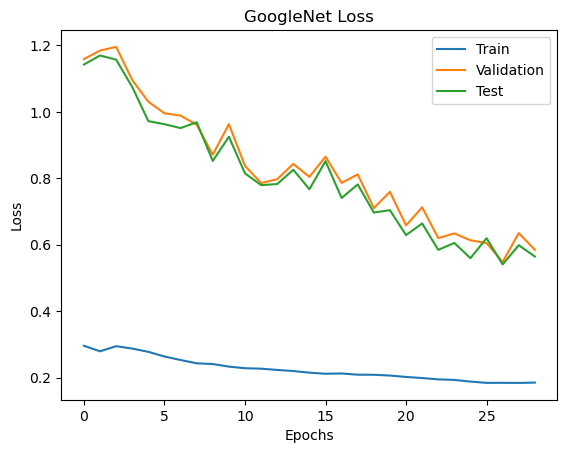

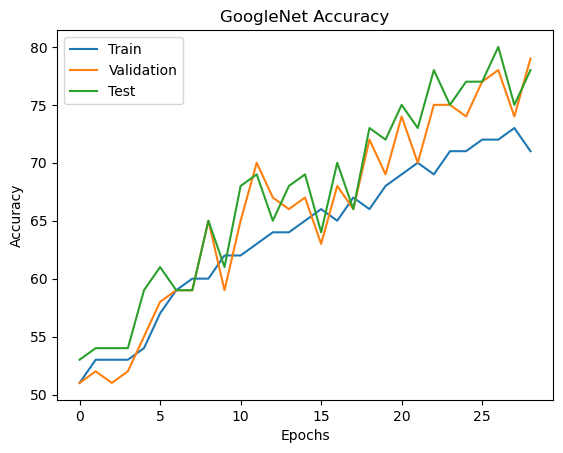

In [10]:
t1 = plt.plot(list(range(epoch1)), tng_loss_list_1, label = 'Train')
t2 = plt.plot(list(range(epoch1)), val_loss_list_1, label = 'Validation')
t3 = plt.plot(list(range(epoch1)), test_loss_list_1, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Loss")
title1 = plt.title('GoogleNet Loss')
le = plt.legend()
plt.show()

a1 = plt.plot(list(range(epoch1)), tng_acc_list_1, label = 'Train')
a2 = plt.plot(list(range(epoch1)), val_acc_list_1, label = 'Validation')
a3 = plt.plot(list(range(epoch1)), test_acc_list_1, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Accuracy")
title1 = plt.title('GoogleNet Accuracy')
le = plt.legend()
plt.show()

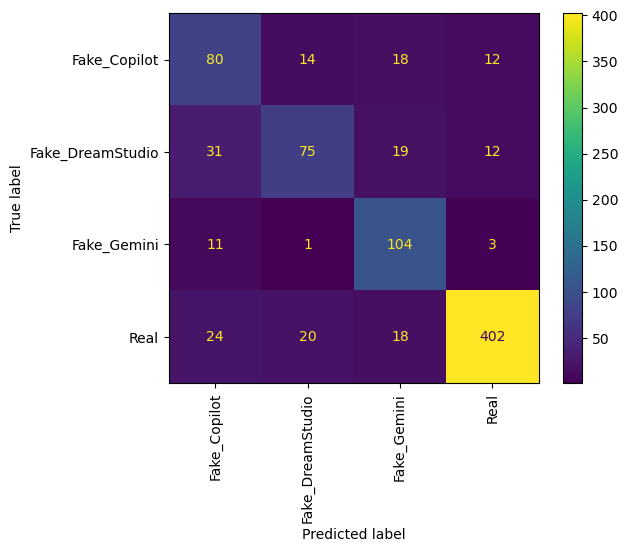

[51, 53, 53, 53, 54, 57, 59, 60, 60, 62, 62, 63, 64, 64, 65, 66, 65, 67, 66, 68, 69, 70, 69, 71, 71, 72, 72, 73, 71]
[51, 52, 51, 52, 55, 58, 59, 59, 65, 59, 65, 70, 67, 66, 67, 63, 68, 66, 72, 69, 74, 70, 75, 75, 74, 77, 78, 74, 79]
[53, 54, 54, 54, 59, 61, 59, 59, 65, 61, 68, 69, 65, 68, 69, 64, 70, 66, 73, 72, 75, 73, 78, 75, 77, 77, 80, 75, 78]


In [11]:
ConfusionMatrixDisplay.from_predictions(y_true_1, y_hat_1, display_labels = classes, xticks_rotation = 'vertical')
plt.show()
print(tng_acc_list_1)
print(val_acc_list_1)
print(test_acc_list_1)

__Model 2: VGG-13__

In [12]:
vgg13 = models.vgg13(weights = None)
vgg13 = vgg13.to(device)

In [13]:
vgg13.classifier[6] = nn.Linear(4096, len(classes), bias = True)

In [14]:
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(vgg13.parameters(), lr=0.01, weight_decay = .0001)

In [15]:
tng_loss_list_2 = []
val_loss_list_2 = []
test_loss_list_2 = []
tng_acc_list_2 = []
val_acc_list_2 = []
test_acc_list_2 = []
correct = 0
total = 0
lr = 0.01

prev_epoch2 = -1
epoch2 = 0
failure_counter2 = 0

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(vgg13.parameters(), lr=lr, weight_decay = .0001)

vgg13.zero_grad()

#for epoch in range(epoch):
while failure_counter2 <= 3:
    vgg13.train().to(device)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_2.zero_grad()
        outputs = vgg13(inputs)
        loss = criterion_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'{epoch2 + 1}, loss: {running_loss / len(train):.3f}')
    tng_loss_list_2.append(running_loss / len(train))
    tng_acc_list_2.append(100 * correct // total)
    running_loss = 0.0
    
    ## Validation Stats ##
    
    correct = 0
    total = 0
    vgg13.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg13(inputs)
            loss = criterion_2(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_acc_list_2.append(100 * correct // total)
    val_loss_list_2.append(running_loss / len(val))
    
    if epoch2 > 1 and tng_loss_list_2[epoch2] > tng_loss_list_2[prev_epoch2]:
        lr = lr/1.5
        print(f'Updated Learning rate:{lr:.5f}')
        failure_counter2 += 1
    
    ## Test Stats ##
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vgg13(inputs)
            loss = criterion_2(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    test_acc_list_2.append(100 * correct // total)
    test_loss_list_2.append(running_loss / len(test))
    
    epoch2 += 1
    prev_epoch2 += 1

print('Finished Training')

1, loss: 0.287
2, loss: 0.258
3, loss: 0.240
4, loss: 0.225
5, loss: 0.211
6, loss: 0.192
7, loss: 0.175
8, loss: 0.158
9, loss: 0.138
10, loss: 0.123
11, loss: 0.110
12, loss: 0.086
13, loss: 0.076
14, loss: 0.061
15, loss: 0.057
16, loss: 0.043
17, loss: 0.044
Updated Learning rate:0.00667
18, loss: 0.030
19, loss: 0.021
20, loss: 0.026
Updated Learning rate:0.00444
21, loss: 0.020
22, loss: 0.014
23, loss: 0.009
24, loss: 0.018
Updated Learning rate:0.00296
25, loss: 0.018
Updated Learning rate:0.00198
Finished Training


In [16]:
running_loss = 0
correct = 0
total = 0
y_hat_2 = []
y_true_2 = []

correct_pred_2 = {classname: 0 for classname in classes}
total_pred_2 = {classname: 0 for classname in classes}
vgg13.eval().to(device)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = vgg13(inputs)
        loss = criterion_2(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        y_hat_2.append(predicted.cpu().numpy())
        y_true_2.append(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred_2[classes[label]] += 1
            total_pred_2[classes[label]] += 1

print(f'Accuracy of the network on the {len(test)} test images: {100 * correct // total} %')
print(f'loss: {running_loss / len(test):.3f}')

for classname, correct_count in correct_pred_2.items():
    accuracy = 100 * float(correct_count) / total_pred_2[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 844 test images: 79 %
loss: 0.828
Accuracy for class: Fake_Copilot is 62.9 %
Accuracy for class: Fake_DreamStudio is 63.5 %
Accuracy for class: Fake_Gemini is 94.1 %
Accuracy for class: Real  is 85.8 %


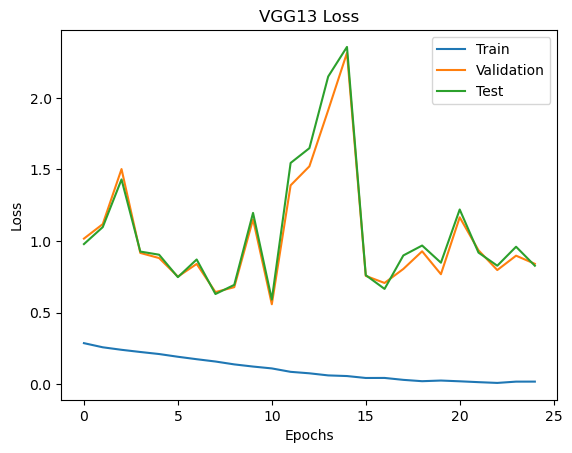

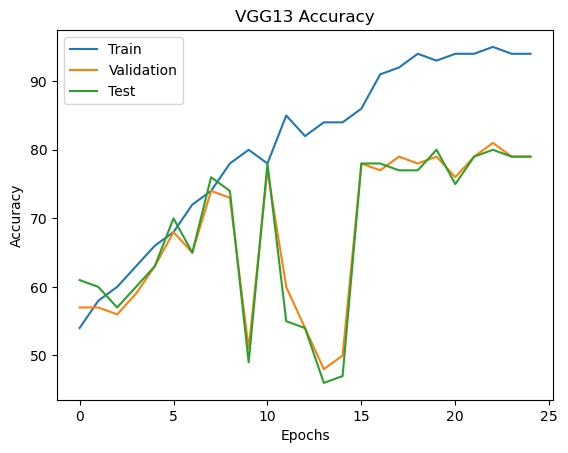

In [17]:
t1 = plt.plot(list(range(epoch2)), tng_loss_list_2, label = 'Train')
t2 = plt.plot(list(range(epoch2)), val_loss_list_2, label = 'Validation')
t3 = plt.plot(list(range(epoch2)), test_loss_list_2, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Loss")
title1 = plt.title('VGG13 Loss')
le = plt.legend()
plt.show()

a1 = plt.plot(list(range(epoch2)), tng_acc_list_2, label = 'Train')
a2 = plt.plot(list(range(epoch2)), val_acc_list_2, label = 'Validation')
a3 = plt.plot(list(range(epoch2)), test_acc_list_2, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Accuracy")
title1 = plt.title('VGG13 Accuracy')
le = plt.legend()
plt.show()

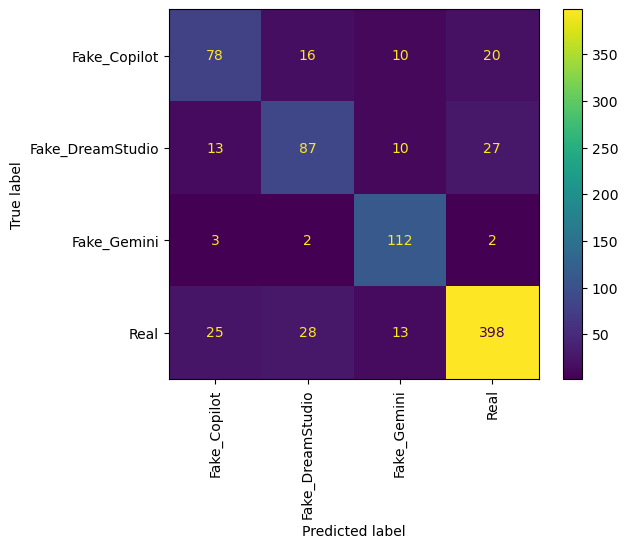

[54, 58, 60, 63, 66, 68, 72, 74, 78, 80, 78, 85, 82, 84, 84, 86, 91, 92, 94, 93, 94, 94, 95, 94, 94]
[57, 57, 56, 59, 63, 68, 65, 74, 73, 51, 77, 60, 54, 48, 50, 78, 77, 79, 78, 79, 76, 79, 81, 79, 79]
[61, 60, 57, 60, 63, 70, 65, 76, 74, 49, 78, 55, 54, 46, 47, 78, 78, 77, 77, 80, 75, 79, 80, 79, 79]


In [18]:
ConfusionMatrixDisplay.from_predictions(y_true_2, y_hat_2, display_labels = classes, xticks_rotation = 'vertical')
plt.show()
print(tng_acc_list_2)
print(val_acc_list_2)
print(test_acc_list_2)

__Model 3: DenseNet-161__

In [19]:
dense_net = models.densenet161(weights = False)
dense_net = dense_net.to(device)
dense_net.classifier = nn.Linear(2208, len(classes), bias = True)

C:\Users\robb4\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(dense_net.parameters(), lr=0.01, weight_decay = .001)

In [21]:
tng_loss_list_3 = []
val_loss_list_3 = []
test_loss_list_3 = []
tng_acc_list_3 = []
val_acc_list_3 = []
test_acc_list_3 = []
correct = 0
total = 0
lr = 0.01

prev_epoch3 = -1
epoch3 = 0
failure_counter3 = 0

dense_net.zero_grad()

criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(dense_net.parameters(), lr=lr, weight_decay = .001)

#for epoch in range(epoch):
while failure_counter3 <= 3:
    dense_net.train().to(device)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_3.zero_grad()
        outputs = dense_net(inputs)
        loss = criterion_3(outputs, labels)
        loss.backward()
        optimizer_3.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'{epoch3 + 1}, loss: {running_loss / len(train):.3f}')
    tng_loss_list_3.append(running_loss / len(train))
    tng_acc_list_3.append(100 * correct // total)
    running_loss = 0.0
    
    ## Validation Stats ##
    
    correct = 0
    total = 0
    dense_net.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = dense_net(inputs)
            loss = criterion_3(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_acc_list_3.append(100 * correct // total)
    val_loss_list_3.append(running_loss / len(val))
    
    if epoch3 > 1 and tng_loss_list_3[epoch3] > tng_loss_list_3[prev_epoch3]:
        lr = lr/1.5
        print(f'Updated Learning rate:{lr:.5f}')
        failure_counter3 += 1
    
    ## Test Stats ##
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = dense_net(inputs)
            loss = criterion_3(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    test_acc_list_3.append(100 * correct // total)
    test_loss_list_3.append(running_loss / len(test))
    
    epoch3 += 1
    prev_epoch3 += 1

print('Finished Training')

1, loss: 0.289
2, loss: 0.250
3, loss: 0.230
4, loss: 0.206
5, loss: 0.195
6, loss: 0.191
7, loss: 0.179
8, loss: 0.171
9, loss: 0.162
10, loss: 0.150
11, loss: 0.146
12, loss: 0.134
13, loss: 0.127
14, loss: 0.130
Updated Learning rate:0.00667
15, loss: 0.122
16, loss: 0.116
17, loss: 0.115
18, loss: 0.106
19, loss: 0.100
20, loss: 0.099
21, loss: 0.096
22, loss: 0.092
23, loss: 0.080
24, loss: 0.079
25, loss: 0.075
26, loss: 0.076
Updated Learning rate:0.00444
27, loss: 0.070
28, loss: 0.065
29, loss: 0.067
Updated Learning rate:0.00296
30, loss: 0.065
31, loss: 0.059
32, loss: 0.056
33, loss: 0.059
Updated Learning rate:0.00198
Finished Training


In [22]:
running_loss = 0
correct = 0
total = 0
y_hat_3 = []
y_true_3 = []
correct_pred_3 = {classname: 0 for classname in classes}
total_pred_3 = {classname: 0 for classname in classes}
dense_net.eval().to(device)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        #labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = dense_net(inputs)
        loss = criterion_3(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        y_hat_3.append(predicted.cpu().numpy())
        y_true_3.append(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred_3[classes[label]] += 1
            total_pred_3[classes[label]] += 1

print(f'Accuracy of the network on the {len(test)} test images: {100 * correct // total} %')
print(f'loss: {running_loss / len(test):.3f}')

for classname, correct_count in correct_pred_3.items():
    accuracy = 100 * float(correct_count) / total_pred_3[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 844 test images: 87 %
loss: 0.449
Accuracy for class: Fake_Copilot is 75.0 %
Accuracy for class: Fake_DreamStudio is 67.2 %
Accuracy for class: Fake_Gemini is 79.8 %
Accuracy for class: Real  is 98.3 %


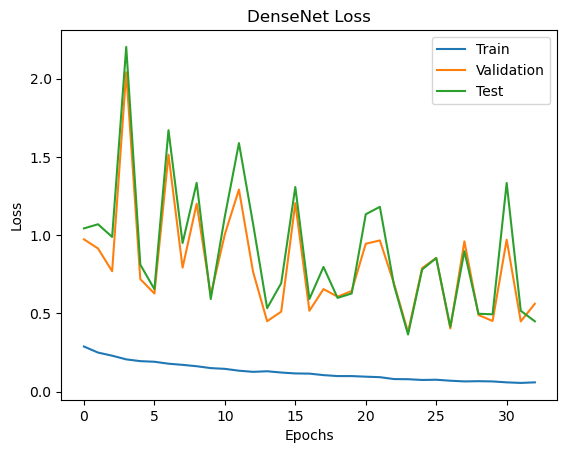

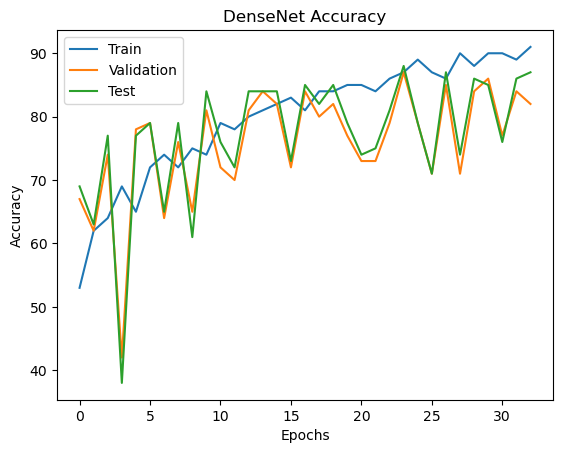

In [23]:
t1 = plt.plot(list(range(epoch3)), tng_loss_list_3, label = 'Train')
t2 = plt.plot(list(range(epoch3)), val_loss_list_3, label = 'Validation')
t3 = plt.plot(list(range(epoch3)), test_loss_list_3, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Loss")
title1 = plt.title('DenseNet Loss')
le = plt.legend()
plt.show()

a1 = plt.plot(list(range(epoch3)), tng_acc_list_3, label = 'Train')
a2 = plt.plot(list(range(epoch3)), val_acc_list_3, label = 'Validation')
a3 = plt.plot(list(range(epoch3)), test_acc_list_3, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Accuracy")
title1 = plt.title('DenseNet Accuracy')
le = plt.legend()
plt.show()

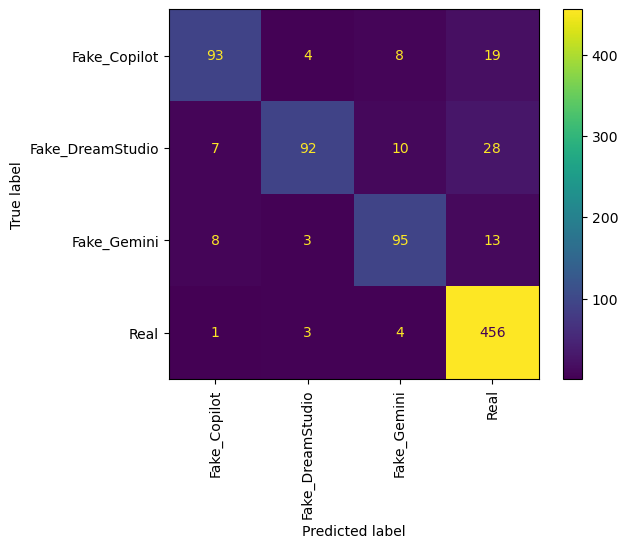

[53, 62, 64, 69, 65, 72, 74, 72, 75, 74, 79, 78, 80, 81, 82, 83, 81, 84, 84, 85, 85, 84, 86, 87, 89, 87, 86, 90, 88, 90, 90, 89, 91]
[67, 62, 74, 42, 78, 79, 64, 76, 65, 81, 72, 70, 81, 84, 82, 72, 84, 80, 82, 77, 73, 73, 79, 87, 79, 71, 85, 71, 84, 86, 77, 84, 82]
[69, 63, 77, 38, 77, 79, 65, 79, 61, 84, 76, 72, 84, 84, 84, 73, 85, 82, 85, 79, 74, 75, 81, 88, 79, 71, 87, 74, 86, 85, 76, 86, 87]


In [24]:
ConfusionMatrixDisplay.from_predictions(y_true_3, y_hat_3, display_labels = classes, xticks_rotation = 'vertical')
plt.show()

print(tng_acc_list_3)
print(val_acc_list_3)
print(test_acc_list_3)

__Model 4: ResNet-101__

In [25]:
res_net = models.resnet101(weights = None)
res_net = res_net.to(device)
res_net.fc = nn.Linear(2048, len(classes), bias = True)

In [26]:
criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(res_net.parameters(), lr=0.01, weight_decay = .001)

In [27]:
tng_loss_list_4 = []
val_loss_list_4 = []
test_loss_list_4 = []
tng_acc_list_4 = []
val_acc_list_4 = []
test_acc_list_4 = []
correct = 0
total = 0
lr = 0.01

prev_epoch4 = -1
epoch4 = 0
failure_counter4 = 0

res_net.zero_grad()

criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(res_net.parameters(), lr=lr, weight_decay = .001)

#for epoch in range(epoch):
while failure_counter4 <= 3:
    res_net.train().to(device)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_4.zero_grad()
        outputs = res_net(inputs)
        loss = criterion_4(outputs, labels)
        loss.backward()
        optimizer_4.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'{epoch4 + 1}, loss: {running_loss / len(train):.3f}')
    tng_loss_list_4.append(running_loss / len(train))
    tng_acc_list_4.append(100 * correct // total)
    running_loss = 0.0
    
    ## Validation Stats ##
    
    correct = 0
    total = 0
    res_net.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = res_net(inputs)
            loss = criterion_4(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_acc_list_4.append(100 * correct // total)
    val_loss_list_4.append(running_loss / len(val))
    
    if epoch4 > 1 and tng_loss_list_4[epoch4] > tng_loss_list_4[prev_epoch4]:
        lr = lr/1.5
        print(f'Updated Learning rate:{lr:.5f}')
        failure_counter4 += 1
    
    ## Test Stats ##
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = res_net(inputs)
            loss = criterion_4(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    test_acc_list_4.append(100 * correct // total)
    test_loss_list_4.append(running_loss / len(test))
    
    epoch4 += 1
    prev_epoch4 += 1

print('Finished Training')

1, loss: 0.461
2, loss: 0.307
3, loss: 0.280
4, loss: 0.260
5, loss: 0.247
6, loss: 0.237
7, loss: 0.239
Updated Learning rate:0.00667
8, loss: 0.218
9, loss: 0.217
10, loss: 0.208
11, loss: 0.201
12, loss: 0.199
13, loss: 0.197
14, loss: 0.184
15, loss: 0.179
16, loss: 0.174
17, loss: 0.165
18, loss: 0.162
19, loss: 0.158
20, loss: 0.149
21, loss: 0.154
Updated Learning rate:0.00444
22, loss: 0.147
23, loss: 0.131
24, loss: 0.125
25, loss: 0.118
26, loss: 0.106
27, loss: 0.106
Updated Learning rate:0.00296
28, loss: 0.105
29, loss: 0.118
Updated Learning rate:0.00198
Finished Training


In [28]:
running_loss = 0
correct = 0
total = 0
y_hat_4 = []
y_true_4 = []
correct_pred_4 = {classname: 0 for classname in classes}
total_pred_4 = {classname: 0 for classname in classes}
res_net.eval().to(device)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        #labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = res_net(inputs)
        loss = criterion_4(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        y_hat_4.append(predicted.cpu().numpy())
        y_true_4.append(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred_4[classes[label]] += 1
            total_pred_4[classes[label]] += 1

print(f'Accuracy of the network on the {len(test)} test images: {100 * correct // total} %')
print(f'loss: {running_loss / len(test):.3f}')

for classname, correct_count in correct_pred_4.items():
    accuracy = 100 * float(correct_count) / total_pred_4[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 844 test images: 77 %
loss: 0.716
Accuracy for class: Fake_Copilot is 71.8 %
Accuracy for class: Fake_DreamStudio is 52.6 %
Accuracy for class: Fake_Gemini is 90.8 %
Accuracy for class: Real  is 83.6 %


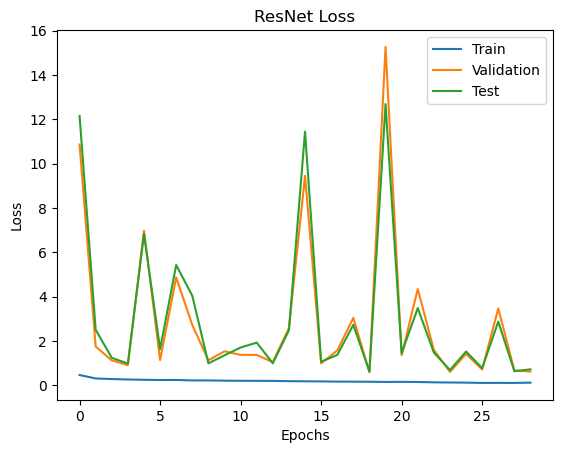

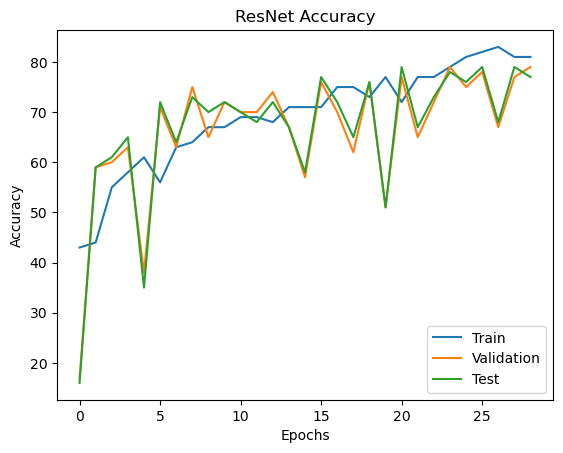

In [29]:
t1 = plt.plot(list(range(epoch4)), tng_loss_list_4, label = 'Train')
t2 = plt.plot(list(range(epoch4)), val_loss_list_4, label = 'Validation')
t3 = plt.plot(list(range(epoch4)), test_loss_list_4, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Loss")
title1 = plt.title('ResNet Loss')
le = plt.legend()
plt.show()

a1 = plt.plot(list(range(epoch4)), tng_acc_list_4, label = 'Train')
a2 = plt.plot(list(range(epoch4)), val_acc_list_4, label = 'Validation')
a3 = plt.plot(list(range(epoch4)), test_acc_list_4, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Accuracy")
title1 = plt.title('ResNet Accuracy')
le = plt.legend()
plt.show()

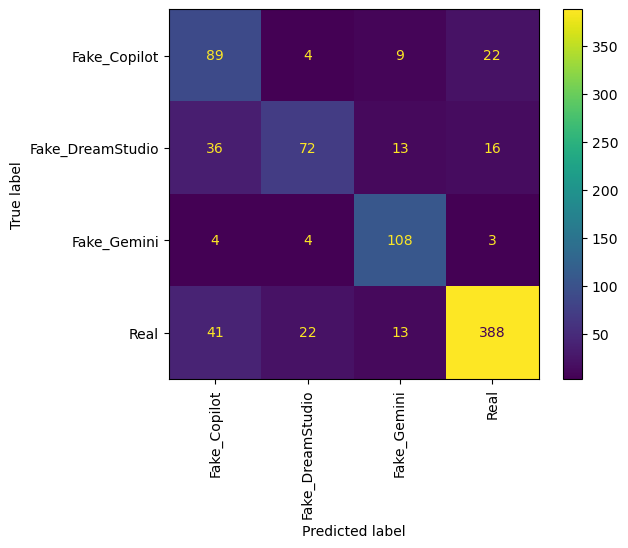

[43, 44, 55, 58, 61, 56, 63, 64, 67, 67, 69, 69, 68, 71, 71, 71, 75, 75, 73, 77, 72, 77, 77, 79, 81, 82, 83, 81, 81]
[17, 59, 60, 63, 38, 71, 63, 75, 65, 72, 70, 70, 74, 67, 57, 76, 70, 62, 76, 51, 77, 65, 72, 79, 75, 78, 67, 77, 79]
[16, 59, 61, 65, 35, 72, 64, 73, 70, 72, 70, 68, 72, 67, 58, 77, 72, 65, 76, 51, 79, 67, 73, 78, 76, 79, 68, 79, 77]


In [30]:
ConfusionMatrixDisplay.from_predictions(y_true_4, y_hat_4, display_labels = classes, xticks_rotation = 'vertical')
plt.show()
print(tng_acc_list_4)
print(val_acc_list_4)
print(test_acc_list_4)

__Model 5: Custom__

In [120]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.SELU(),
            nn.Conv2d(16, 16, 3),
            nn.SELU(),
            nn.Conv2d(16, 32, 3),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            nn.SELU(),
            nn.Conv2d(32, 64, 3),
            nn.SELU(),
            nn.Conv2d(64, 64, 3),
            nn.SELU(),
            nn.Conv2d(64, 128, 3),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, 3),
            nn.SELU(),
            nn.Conv2d(128, 256, 3),
            nn.SELU(),
            nn.Conv2d(256, 256, 3),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 128, 3),
            nn.SELU(),
            nn.Conv2d(128, 64, 3),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(5184, 3200),
            nn.Dropout(p=0.2),
            nn.Linear(3200, 1000),
            nn.Dropout(p=0.2),
            nn.Linear(1000, 4)
        )
         
    def forward(self, x):
        x = self.cnn(x)
        return x
    
model_5 = CNN()

In [121]:
tng_loss_list_5 = []
val_loss_list_5 = []
test_loss_list_5 = []
tng_acc_list_5 = []
val_acc_list_5 = []
test_acc_list_5 = []
correct = 0
total = 0
lr = 0.0005

prev_epoch5 = -1
epoch5 = 31
failure_counter5 = 0

model_5.zero_grad()

criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(model_5.parameters(), lr=lr)

for epoch in range(1, epoch5):
#while failure_counter5 <=4:
    model_5.train().to(device)
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_5.zero_grad()
        outputs = model_5(inputs)
        loss = criterion_5(outputs, labels)
        loss.backward()
        optimizer_5.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'{epoch}, loss: {running_loss / len(train):.3f}')
    tng_loss_list_5.append(running_loss / len(train))
    tng_acc_list_5.append(100 * correct // total)
    running_loss = 0.0
    
    ## Validation Stats ##
    
    correct = 0
    total = 0
    model_5.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_5(inputs)
            loss = criterion_5(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_acc_list_5.append(100 * correct // total)
    val_loss_list_5.append(running_loss / len(val))
    
    if epoch % 7 == 0:
        lr = lr/2
        print(f'Updated Learning rate:{lr:.5f}')
        
    
    ## Test Stats ##
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_5(inputs)
            loss = criterion_5(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    test_acc_list_5.append(100 * correct // total)
    test_loss_list_5.append(running_loss / len(test))
    
    #epoch5 += 1
    #prev_epoch5 += 1

print('Finished Training')

1, loss: 0.314
2, loss: 0.297
3, loss: 0.290
4, loss: 0.273
5, loss: 0.262
6, loss: 0.253
7, loss: 0.245
Updated Learning rate:0.00025
8, loss: 0.236
9, loss: 0.225
10, loss: 0.216
11, loss: 0.208
12, loss: 0.202
13, loss: 0.196
14, loss: 0.187
Updated Learning rate:0.00013
15, loss: 0.182
16, loss: 0.174
17, loss: 0.171
18, loss: 0.166
19, loss: 0.160
20, loss: 0.157
21, loss: 0.151
Updated Learning rate:0.00006
22, loss: 0.147
23, loss: 0.144
24, loss: 0.140
25, loss: 0.136
26, loss: 0.130
27, loss: 0.127
28, loss: 0.123
Updated Learning rate:0.00003
29, loss: 0.119
30, loss: 0.113
Finished Training


In [122]:
running_loss = 0
correct = 0
total = 0
y_hat_5 = []
y_true_5 = []
correct_pred_5 = {classname: 0 for classname in classes}
total_pred_5 = {classname: 0 for classname in classes}
model_5.eval().to(device)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_5(inputs)
        loss = criterion_5(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        y_hat_5.append(predicted.cpu().numpy())
        y_true_5.append(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred_5[classes[label]] += 1
            total_pred_5[classes[label]] += 1

print(f'Accuracy of the network on the {len(test)} test images: {100 * correct // total} %')
print(f'loss: {running_loss / len(test):.3f}')

for classname, correct_count in correct_pred_5.items():
    accuracy = 100 * float(correct_count) / total_pred_5[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 844 test images: 77 %
loss: 0.600
Accuracy for class: Fake_Copilot is 38.7 %
Accuracy for class: Fake_DreamStudio is 65.0 %
Accuracy for class: Fake_Gemini is 85.7 %
Accuracy for class: Real  is 90.1 %


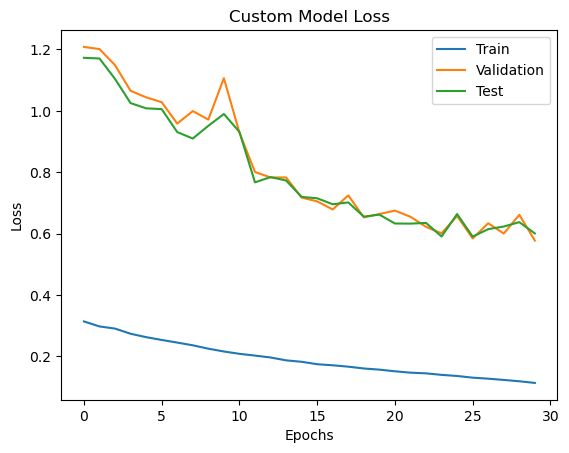

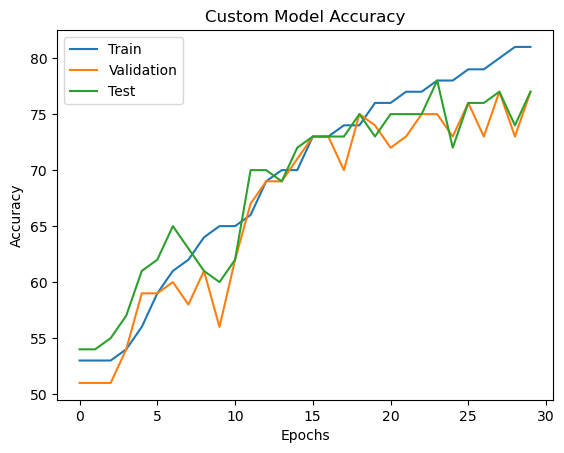

In [123]:
t1 = plt.plot(list(range(epoch5-1)), tng_loss_list_5, label = 'Train')
t2 = plt.plot(list(range(epoch5-1)), val_loss_list_5, label = 'Validation')
t3 = plt.plot(list(range(epoch5-1)), test_loss_list_5, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Loss")
title1 = plt.title('Custom Model Loss')
le = plt.legend()
plt.show()

a1 = plt.plot(list(range(epoch5-1)), tng_acc_list_5, label = 'Train')
a2 = plt.plot(list(range(epoch5-1)), val_acc_list_5, label = 'Validation')
a3 = plt.plot(list(range(epoch5-1)), test_acc_list_5, label = 'Test')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Accuracy")
title1 = plt.title('Custom Model Accuracy')
le = plt.legend()
plt.show()

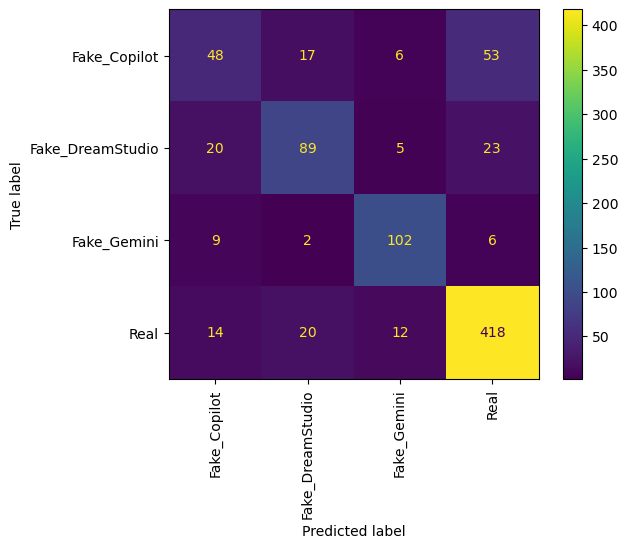

[53, 53, 53, 54, 56, 59, 61, 62, 64, 65, 65, 66, 69, 70, 70, 73, 73, 74, 74, 76, 76, 77, 77, 78, 78, 79, 79, 80, 81, 81]
[51, 51, 51, 54, 59, 59, 60, 58, 61, 56, 62, 67, 69, 69, 71, 73, 73, 70, 75, 74, 72, 73, 75, 75, 73, 76, 73, 77, 73, 77]
[54, 54, 55, 57, 61, 62, 65, 63, 61, 60, 62, 70, 70, 69, 72, 73, 73, 73, 75, 73, 75, 75, 75, 78, 72, 76, 76, 77, 74, 77]


In [124]:
ConfusionMatrixDisplay.from_predictions(y_true_5, y_hat_5, display_labels = classes, xticks_rotation = 'vertical')
plt.show()
print(tng_acc_list_5)
print(val_acc_list_5)
print(test_acc_list_5)

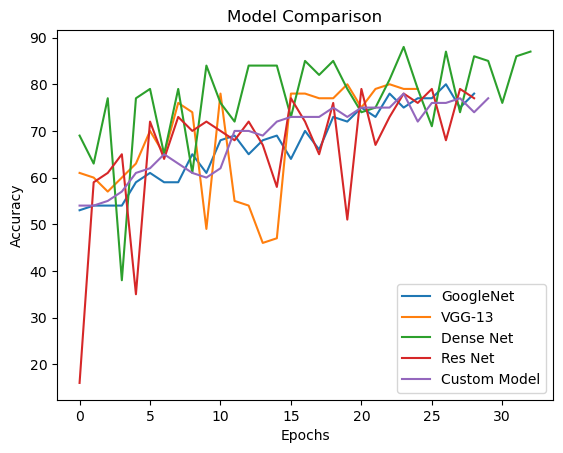

In [127]:
a1 = plt.plot(list(range(epoch1)), test_acc_list_1, label = 'GoogleNet')
a2 = plt.plot(list(range(epoch2)), test_acc_list_2, label = 'VGG-13')
a3 = plt.plot(list(range(epoch3)), test_acc_list_3, label = 'Dense Net')
a4 = plt.plot(list(range(epoch4)), test_acc_list_4, label = 'Res Net')
a5 = plt.plot(list(range(epoch5-1)), test_acc_list_5, label = 'Custom Model')

xl1 = plt.xlabel("Epochs")
yl1 = plt.ylabel("Accuracy")
title1 = plt.title('Model Comparison')
le = plt.legend()
plt.show()

In [37]:
#from PIL import Image
#import torchvision.transforms.functional as TF

#def one_prediction(img):
#    preds = {classname: 0 for classname in classes}
#    #img = Image.open(path).convert('RGB')
#    img = transform(img).to(device)
#    img.unsqueeze_(0)
#    models = [dense_net, googlenet, vgg13, res_net]
    #dense_net.eval()
#    with torch.no_grad():
#        for model in models:
#            model.eval()
#            output = model(img)
#            _, predicted = torch.max(output.data, 1)
#            preds[classes[predicted]] += 1
#    for classname, count in preds.items():
#        chance = float(count) / len(classes)
#        preds[classname] = chance
#    return preds


In [128]:
from PIL import Image
import torchvision.transforms.functional as TF

correct_pred_dict_list = [correct_pred_1, correct_pred_2, correct_pred_3, correct_pred_4, correct_pred_5]
total_pred_dict_list = [total_pred_1, total_pred_2, total_pred_3, total_pred_4, total_pred_5]
chance_dict = {}

def one_prediction(img):
    preds = {classname: 0 for classname in classes}
    img = transform(img).to(device)
    img.unsqueeze_(0)
    models = [dense_net, googlenet, vgg13, res_net, model_5]
    with torch.no_grad():
        for i, model in enumerate(models):
            model.eval()
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            preds[classes[predicted]] += 1 * (correct_pred_dict_list[i][classes[predicted]]/total_pred_dict_list[i][classes[predicted]])
    for classname, count in preds.items():
        chance = float(count) / sum(preds.values())
        chance_dict[classname] = round(chance, 3)
    return chance_dict

In [134]:
total_pred_dict_list

[{'Fake_Copilot': 124,
  'Fake_DreamStudio': 137,
  'Fake_Gemini': 119,
  'Real': 464},
 {'Fake_Copilot': 124,
  'Fake_DreamStudio': 137,
  'Fake_Gemini': 119,
  'Real': 464},
 {'Fake_Copilot': 124,
  'Fake_DreamStudio': 137,
  'Fake_Gemini': 119,
  'Real': 464},
 {'Fake_Copilot': 124,
  'Fake_DreamStudio': 137,
  'Fake_Gemini': 119,
  'Real': 464},
 {'Fake_Copilot': 124,
  'Fake_DreamStudio': 137,
  'Fake_Gemini': 119,
  'Real': 464}]

In [129]:
path = 'C:/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/One/dream_example.png'
img = Image.open(path).convert('RGB')
test1 = one_prediction(img)
test1

{'Fake_Copilot': 0.0, 'Fake_DreamStudio': 1.0, 'Fake_Gemini': 0.0, 'Real': 0.0}

In [132]:
d_path = '/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/dense.pth'
torch.save(dense_net.state_dict(), d_path)
g_path = '/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/google.pth'
torch.save(googlenet.state_dict(), g_path)
r_path = '/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/resnet.pth'
torch.save(res_net.state_dict(), r_path)
v_path = '/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/vgg13.pth'
torch.save(vgg13.state_dict(), v_path)
cust_path = '/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/cust.pth'
torch.save(model_5.state_dict(), cust_path)

In [130]:
import gradio as gr

In [131]:
title = "Real vs Fake Image Classification"
description = "Test."
article = "Test"
examples = [['C:/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/One/dream_example.png'],
           ['C:/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/One/real_example.png'],
           ['C:/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/One/gemini_example.jpg'],
           ['C:/Users/robb4/OneDrive/Desktop/DATA SCIENCE MPS/Summer 24/Deep Learning/Final Project/One/copilot_example.png']]

demo = gr.Interface(fn=one_prediction, 
                    inputs=gr.Image(type="pil"),
                    outputs=gr.Label(num_top_classes=4, label="Predictions"),
                    examples=examples, 
                    title=title,
                    description=description,
                    article=article)
demo.launch(debug=False,
            share=True)

Running on local URL:  http://127.0.0.1:7863

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\robb4\anaconda3\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 399, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\robb4\anaconda3\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 70, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\robb4\anaconda3\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\robb4\anaconda3\Lib\site-packages\starlette\applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\robb4\anaconda3\Lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "C:\Users\robb4\anaconda3\Lib\site-packages\starlett